# Stage 1: Map Matching

## **Input**: trajectories, 

## **Output**: each GPS point should have one corresponding matched road segment.


In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.functional as F
import os, sys
import math
import osmnx as ox
from shapely.geometry import shape, Point, LineString, MultiLineString
from sklearn.metrics.pairwise import haversine_distances
import networkx as nx
import folium

RADIUS_OF_EARTH_M = 6371000
MILES_PER_METER = 0.000621371
HOURS_PER_SECOND = 3600.0

# Basic Algorithm

In [2]:
# great circle distance 
def great_circle_dist_x_to_z(x, z):
    # convert decimal degrees to radians 
    x = np.deg2rad(x)
    z = np.deg2rad(z)
    
    longitude = z[1]
    latitude = z[0]
    prev_longitude = x[1]
    prev_latitude = x[0]
    
    # haversine formula 
    dlon = longitude - prev_longitude # lon2 - lon1 
    dlat = latitude - prev_latitude # lat2 - lat1 
    
    # a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    a = np.add(np.square(np.sin(dlat / 2)),
               np.multiply(np.cos(prev_latitude), 
                           np.multiply(np.cos(latitude), np.square(np.sin(dlon / 2)))
                          )
              )
    
    # c = 2 * asin(sqrt(a)) 
    c = np.arcsin(np.sqrt(a)) * 2
    
    return RADIUS_OF_EARTH_M * c

In [3]:
# great circle distance 
def great_circle_dist_z_to_z(df):
    # convert decimal degrees to radians 
    df = df.copy()
    df = np.deg2rad(df)
    
    longitude = df[:, 3]
    latitude = df[:, 2]
    prev_longitude = df[:, 1]
    prev_latitude = df[:, 0]
    
    # haversine formula 
    dlon = longitude - prev_longitude # lon2 - lon1 
    dlat = latitude - prev_latitude # lat2 - lat1 
    
    # a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    a = np.add(np.square(np.sin(dlat / 2)),
               np.multiply(np.cos(prev_latitude), 
                           np.multiply(np.cos(latitude), np.square(np.sin(dlon / 2)))
                          )
              )
    
    # c = 2 * asin(sqrt(a)) 
    c = np.arcsin(np.sqrt(a)) * 2
    
    return RADIUS_OF_EARTH_M * c

In [4]:
# get the x_t_i
def get_perpendicular_point(point, line):
    # point: (x, y)
    # line: ((x1, y1), (x2, y2))
    
    x, y = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    
    # calculate the slope of the line
    if x2 - x1 == 0:
        # vertical line
        x_intersect = x1
        y_intersect = y
    else:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
    
        # calculate the intersection point of the line and the perpendicular line
        x_intersect = (slope*y + x - slope*intercept) / (slope**2 + 1)
        y_intersect = (slope*x_intersect) + intercept
        
    return [x_intersect, y_intersect]

In [5]:
def get_route(G, p1, p2):
    # get the nearest network node to each point
    orig_node = ox.nearest_nodes(G, p1[0], p1[1])
    dest_node = ox.nearest_nodes(G, p2[0], p2[1])

    # how long is our route in meters?
    return nx.shortest_path_length(G, orig_node, dest_node, weight='length')

In [6]:
def get_slope(coordA, coordB):
    #(x1, y1) and (x2, y2)
    x1 = coordA[0] # start lat
    y1 = coordA[1] # start long
    x2 = coordB[0] # end lat
    y2 = coordB[1] # end long
    
    if (x2 - x1) == 0:
        return 0
    else:
        return (y2 - y1) // (x2 - x1)

# HMM Model

In [7]:
## HMM model
class HMMModel(nn.Module):
    def __init__(self, G, viterbi_trellis=[], viterbi_list =[], 
                 sigma = 4.07, beta = 3.0, normalize=True, 
                 prob_floor=0.0, n = 50, prev_candidate_roads = []):
        self.G = G
        self.normalize = normalize
        self.prob_floor = min(max(prob_floor, 0), 1)
        self.n = n
        self.sigma = sigma
        self.beta = beta
        self.weights = np.zeros((1, self.n))
        self.viterbi_trellis = viterbi_trellis  # list of particle np arrays
        self.prev_candidate_roads = prev_candidate_roads
        self.viterbi_list = viterbi_list
      
    def apply_emission_model(self, sampled_states, obs_coords):
        # TODO: simplify the code below
        # get the sigma 
        # 1.4826 median𝑡(‖𝑧𝑡 − 𝑥𝑡,𝑖∗‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒)
        
        probs = []
        for obs in sampled_states:
            # ‖𝑧𝑡 − 𝑥𝑡,𝑖‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒
            dist_obs_roads = obs[1].Z_t_TO_X_t_i
            
            # 𝑝(𝑧𝑡|𝑟𝑖)
            probs.append(np.exp(np.power(dist_obs_roads / self.sigma, 2) * (-0.5)) * (1 / (math.sqrt(2 * math.pi) * self.sigma)))

        # Normalize result
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs
    
    def apply_transition_model(self, candidate_roads, dist_prev):
        # TODO: simplify the code below
        # get the beta
        # 𝛽 = 1/ln(2) mediant (|‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 − ‖𝑥𝑡,𝑖∗ −𝑥𝑡+1,𝑗∗‖𝑟𝑜𝑢𝑡𝑒|)
        
        probs = []
        # NOTE: ‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 is given by dist_prev
        for point in candidate_roads:
            prob = []
            for prev_point in self.prev_candidate_roads:
                # calculate ‖𝑥𝑡,𝑖 − 𝑥𝑡+1,𝑗‖𝑟𝑜𝑢𝑡𝑒 
                # TODO: need to recalculate the route
                # using a conventional route planner configured 
                # to give the route with the shortest distance
                dist_road = get_route(self.G, (prev_point[1].X_t_i[0], prev_point[1].X_t_i[1]), (point[1].X_t_i[0], point[1].X_t_i[1]))
                
                # TODO: terminate the search for a route when ‖𝑥𝑡,𝑖 − 𝑥𝑡+1,𝑗‖𝑟𝑜𝑢𝑡𝑒 
                # becomes greater than ‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 by 2000 meters
                # or more, and assign a probability of zero.
                
                # calculate the difference between ‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 and ‖𝑥𝑡,𝑖 − 𝑥𝑡+1,𝑗‖𝑟𝑜𝑢𝑡𝑒
                diff_dist = np.abs(np.subtract(dist_road, dist_prev))
                if diff_dist > 65:
                    prob.append(0)
                else:
                    # calculate the transition probability
                    prob.append(np.exp(-diff_dist / self.beta) * (1 / self.beta))
                
            probs.append(prob)
        
        # Normalize result?
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs  # the probs is a list of lists transition prob
    
    def update_dist(self, obs, candidate_roads, num_iter, n, max_dist2=None):
#         print(obs)
        longitude = obs[1].longitude
        latitude = obs[1].latitude
        
        # n depends on how many candidate roads you have at time t
        self.n = n
        
        obs_coords = [latitude, longitude] 
        dist_prev = obs[1].dist_from_prev_m
        
        # transition probability
        if num_iter > 1:
            
            trans_probs = self.apply_transition_model(candidate_roads, 
                                                      dist_prev) # (n * c, 1) first n rows for first candidate, etc.
            sampled_states = candidate_roads
#             print("Transition: ")
#             print(trans_probs)
#             print("--------------------------------------------------------------")
        else:
            sampled_states = candidate_roads
        
        # emission probabilities
        emission_probs = self.apply_emission_model(sampled_states, obs_coords) # (n, 1)
#         print("Emission: ")
#         print(emission_probs)
#         print("--------------------------------------------------------------")
        
        # Joint prob, for viterbi backtracking.
        if num_iter > 1:
            # since the num_iter is different we need to v(j)
            max_v_list = []
            max_v = 0
            for i in range(len(emission_probs)):
                for j in range(len(trans_probs[i])):
                    # get the Recursion
                    joint = np.multiply(self.weights[j], np.multiply(emission_probs[i], trans_probs[i][j]))
                    if max_v < joint:
                        max_v = joint
                max_v_list.append(max_v)
                max_v = 0
#             print("Max_v: ")
#             print(max_v_list)
#             print("--------------------------------------------------------------")
            # the recursion for other states
            joint_prob = max_v_list
            # for other states, the prob for each road is the joint_prob
            self.viterbi_trellis.append(joint_prob)
            self.viterbi_list.append(candidate_roads)
        else:
            # the recursion for the first state
            joint_prob = emission_probs
            # since it is the first state, the prob for each road is the emission itself
            self.viterbi_trellis.append(joint_prob)
            # remember each candidate_roads place
            self.viterbi_list.append(candidate_roads)
            
        # rememeber the current recursion
        self.weights = joint_prob
        # remember the previous candidate_roads
        self.prev_candidate_roads = candidate_roads
        # TODO: Maybe record the back-pointers?
        
        # Estimate current particle filter fit quality of hypotheses to data; should research good metrics more.
        fit_quality = [np.max(self.weights), np.mean(self.weights), np.median(self.weights)]
        
        return fit_quality
    
    def viterbi(self):
        # Start with the last observation to the viterbi trellis
        best_last_state_idx = np.argmax(self.weights)
        backtracked_states = []
        # Backtrack through the viterbi trellis (#obs, n, 2) actual lat/long states
        for j in range(len(self.viterbi_trellis) - 1 , -1, -1):
            best_last_state = self.viterbi_list[j][best_last_state_idx]
            backtracked_states.append([best_last_state[1].StartNodeLat, best_last_state[1].StartNodeLong])
            best_last_state_idx = np.argmax(self.viterbi_trellis[j - 1])
        # Put in chronological order
        backtracked_states = backtracked_states[::-1]
        return backtracked_states

# Preprocess Data & Grab the Candidate road

In [8]:
# preprocess the data
def preprocess_traces(df, sigma=4.07):
    data = df.copy()
    data[["prev_latitude", "prev_longitude"]] = data[["latitude", "longitude"]].shift(-1)
    # Ignore warning about invalid value in arcsin (nan)
    data["dist_from_prev_m"] = great_circle_dist_z_to_z(data[["prev_latitude", "prev_longitude", "latitude", "longitude"]].values)  # 1.93 sec
    # Take cumsum of dist
    dist_cum = data.dist_from_prev_m.cumsum()
    # removing points that are within 2𝜎 of the previous included point.
    # Select points closest to multiples of 2*sigma, in cumsum dist
    dist_cum_idx = dist_cum // (2 * sigma)
    filter_idx = np.subtract(dist_cum_idx, dist_cum_idx.shift(1)) == 0
    data = data[~filter_idx]
    
    # seperate the route based on the occupancy
    trips_list = []
    trip = []
    # for loop all the point
    for obs in data.iterrows():
        # if this point's occupancy is 1
        if obs[1].occupancy == 1:
            trip.append(obs)
        else:
            trips_list.append(trip)
            trip = []
    trips_list = [x for x in trips_list if x != []]
    return trips_list

In [9]:
# preprocess the Map
def preprocess_Map(G, nodes_p):
    # get the node
    data_node = pd.DataFrame(columns=['NodeID', 'Latitude', 'Longitude'])
    for nodeid, row in nodes_p.iterrows():
      nodeid, latitude,longitude = (nodeid,row['y'], row['x']) 
      new_row = {'NodeID': nodeid, 'Latitude': latitude, 'Longitude': longitude}
      data_node = pd.concat([data_node, pd.DataFrame([new_row])])
    # get the edge
    data_edge = pd.DataFrame(columns=['StartNodeID', 'EndNodeID'])
    for node_id_1, node_id_2,_ in G.edges:
      StartNodeID,EndNodeID = (node_id_1,node_id_2)    
      new_row = {'StartNodeID': node_id_1, 'EndNodeID': node_id_2}
      data_edge = pd.concat([data_edge, pd.DataFrame([new_row])])

    data_node.rename(columns = {'NodeID':'StartNodeID', 'Longitude':'StartNodeLong', 'Latitude':'StartNodeLat'}, inplace = True)
    df_merge = pd.merge(data_edge, data_node, on="StartNodeID")

    data_node.rename(columns = {'StartNodeID':'EndNodeID', 'StartNodeLong':'EndNodeLong', 'StartNodeLat':'EndNodeLat' }, inplace = True)
    df_merge = pd.merge(df_merge, data_node, on="EndNodeID")
    
    return df_merge

In [10]:
# get the candidate road
# TODO: 
# Since we know we are tracking ordinary vehicles on public streets, if a 
# calculated route would require the vehicle to exceed a speed of 50 m/s 
# (112 miles per hour, 180 kilometers per hour), or travel in excess of 
# three times the posted speed limit, we consider the route to be unreasonable,
# and set its probability to zero.

def get_candidate_roads(Map, data):
    # [candidate road for time 0, candidate road for time 1,....]
    candidate_roads = [] 
    # let's get the candidate roads for each time t
    i = 0
    for obs in data:
        # get the lat and long for the point
        z_long = obs[1].longitude
        z_lat = obs[1].latitude
        z = [z_lat, z_long]
        # match the coords and the dataset
        candidate_road = []
        for edge in Map.iterrows():
            p1 = np.array([edge[1].StartNodeLat, edge[1].StartNodeLong])
            p2 = np.array([edge[1].EndNodeLat, edge[1].EndNodeLong])
            p3 = np.array(z)
            
            # 𝑥𝑡,𝑖: the perpendicular point from the z to the road 
            x_t_i = get_perpendicular_point(p3, (p1, p2))
            
            # check if 𝑥𝑡,𝑖 is on the line
            dist_p1_x = great_circle_dist_x_to_z(p1, x_t_i)
            dist_p2_x = great_circle_dist_x_to_z(p2, x_t_i)
            dist_p1_p2 = great_circle_dist_x_to_z(p1, p2)
            
            if ((dist_p1_x + dist_p2_x) - dist_p1_p2)/2 > 50:
                continue
            
            # calculate the distance from the point to the road
            d = great_circle_dist_x_to_z(p3, x_t_i)
#             if i == 3:
#                 print(d)
            # Any road segment more than 200 meters away from the GPS point.
            if d < 60:
#                 print(p1)
#                 print(p2)
#                 print(p3)
#                 print(x_t_i)
                edge[1]['X_t_i'] = x_t_i
                edge[1]['Z_t_TO_X_t_i'] = d
                edge[1]['Z_t_TO_Z_t1'] = obs[1].dist_from_prev_m
                candidate_road.append(edge)
        i += 1
        # TODO: When a break is detected between time step 𝑡 and time step 𝑡 + 1, 
        # we remove measured points 𝑧𝑡 and 𝑧𝑡+1 from the model, and check to see 
        # if the break has been healed. The break is considered healed if the 
        # measured points at 𝑡 − 1 and 𝑡 + 2 lead to a reconnection in the HMM 
        # after rechecking the points with the bulleted conditions above. If the 
        # break is still present, we continue to remove the points on either side 
        # of the break until either the break is healed, or the break is more than 
        # 180 seconds long. 
        if len(candidate_road) == 0:
#             print(z)
            print("No matching roads found within max road distance! Aborting particle filter.")
            return None
        candidate_roads.append(candidate_road)
    return candidate_roads

In [11]:
# densify the trip
def trip_densify(trip):
    delta_t = 15
    temp_list = pd.DataFrame(columns=['latitude', 'longitude', 'occupancy', 'time'])
    # Loop through each pair of consecutive GPS points in the trajectory
    for i in range(len(trip) - 1):
#         if trip[i][1]['dist_from_prev_m'] < 100:
#             continue
        # Calculate the time difference between the two GPS points
        dt = (trip[i+1][1]['time'] - trip[i][1]['time']).total_seconds()
        # Calculate the number of additional points needed to achieve the desired sampling frequency
        n = int(np.ceil(dt / delta_t)) - 1
        # Interpolate between the two GPS points to generate the additional points
        for j in range(n):
            t = (j + 1) * delta_t / dt
            lat = (1 - t) * trip[i][1]['latitude'] + t * trip[i+1][1]['latitude']
            long = (1 - t) * trip[i][1]['longitude'] + t * trip[i+1][1]['longitude']
            new_time = trip[i][1]['time'] + pd.Timedelta((j + 1) * delta_t, unit='s')
            new_point =  {'latitude': lat,
                         'longitude': long,
                         'occupancy': 1,
                         'time': new_time}
            temp_list = pd.concat([temp_list, pd.DataFrame([new_point])]).reset_index(drop=True)
    # Combine the original trajectory with the new points to create the densified trajectory
    dens_trip = trip.copy()
    dealing_list = pd.DataFrame(columns=['latitude', 'longitude', 'occupancy', 'time'])
    num = 0
    for x in dens_trip:
        orig_point =  {'latitude': x[1].latitude,
                       'longitude': x[1].longitude,
                       'occupancy': 1,
                       'time': x[1].time}
        num += 1
        dealing_list = pd.concat([dealing_list, pd.DataFrame([orig_point])]).reset_index(drop=True)
    traj_dens = pd.concat([dealing_list, temp_list], ignore_index=True).reset_index(drop=True)
    traj_dens = traj_dens.sort_values('time').reset_index(drop=True)
    
    # print(c_trip)
    data = traj_dens.copy()
    data = data.sort_values(by='time', ascending=False).reset_index(drop=True)
    data[["prev_latitude", "prev_longitude"]] = data[["latitude", "longitude"]].shift(-1)
    # Ignore warning about invalid value in arcsin (nan)
    data["dist_from_prev_m"] = great_circle_dist_z_to_z(data[["prev_latitude", "prev_longitude", "latitude", "longitude"]].values)  # 1.93 sec
    
    return data

# Load the Data and Training

In [12]:
# get the training path
train_path = './training/'

In [13]:
# get the Map
bounds = [-122.5206, 37.8152, -122.3554, 37.7088]
north, south, east, west = bounds[1], bounds[3], bounds[2], bounds[0]
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
nodes_p, edges_p = ox.graph_to_gdfs(G, nodes= True, edges = True)
Map = preprocess_Map(G, nodes_p)

In [25]:
# get all the files in the training folder
all_files = [f for f in os.listdir(train_path)]

# read the 1st file in the folder as a test case
train_df = pd.read_csv(os.path.join(train_path, all_files[362]), sep=" ", index_col=None, header=None, 
                      names=['latitude', 'longitude', 'occupancy', 'time'])

# convert the time from unix into date time
train_df.loc[:, ["time"]] = pd.to_datetime(train_df.time, origin="unix", unit='s')

# preprocess the data
trips_list = preprocess_traces(train_df)


# pick one trip for HMM training
# [0, 131]
trip = trips_list[131]

# increase the point for one trip
trip = sorted(trip, key = lambda point: point[1]['time'])
c_trip = trip_densify(trip)
final_trip = c_trip.copy()
final_trip.loc[len(final_trip)-1, 'prev_latitude'] = trip[0][1][4]
final_trip.loc[len(final_trip)-1, 'prev_longitude'] = trip[0][1][5]
final_trip.loc[len(final_trip)-1, 'dist_from_prev_m'] = trip[0][1][6]
trip = []
for data in final_trip.iterrows():
    trip.append(data)
    
# # get the candidate roads
candidate_roads = get_candidate_roads(Map, trip)

(-122.41889, -122.41561297297297)

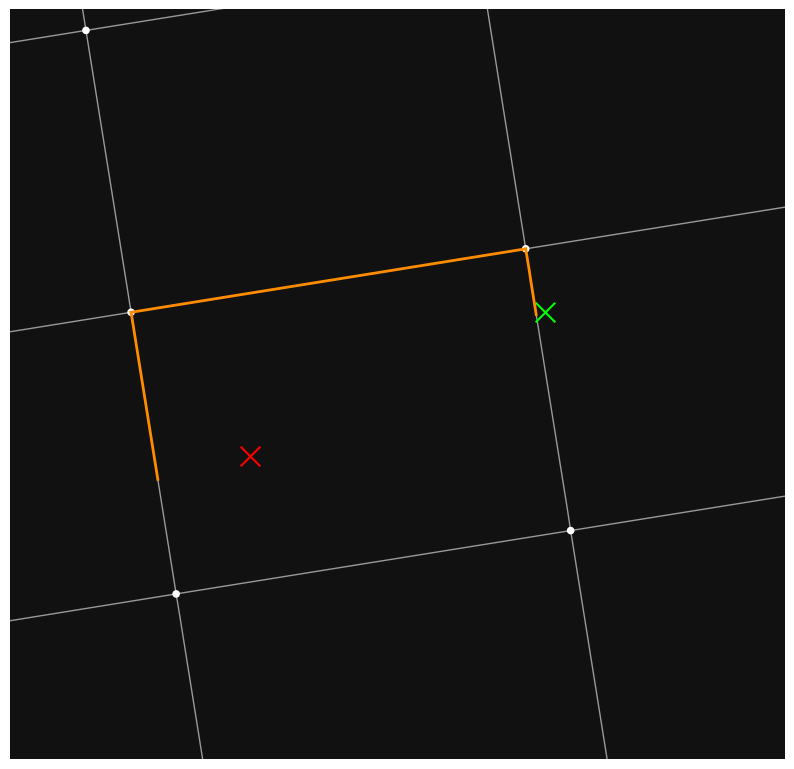

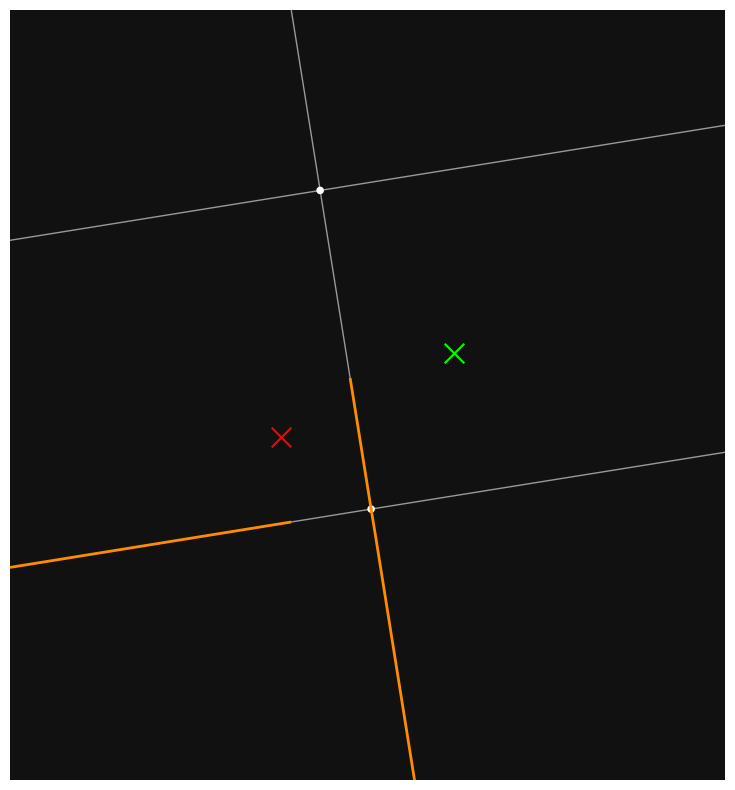

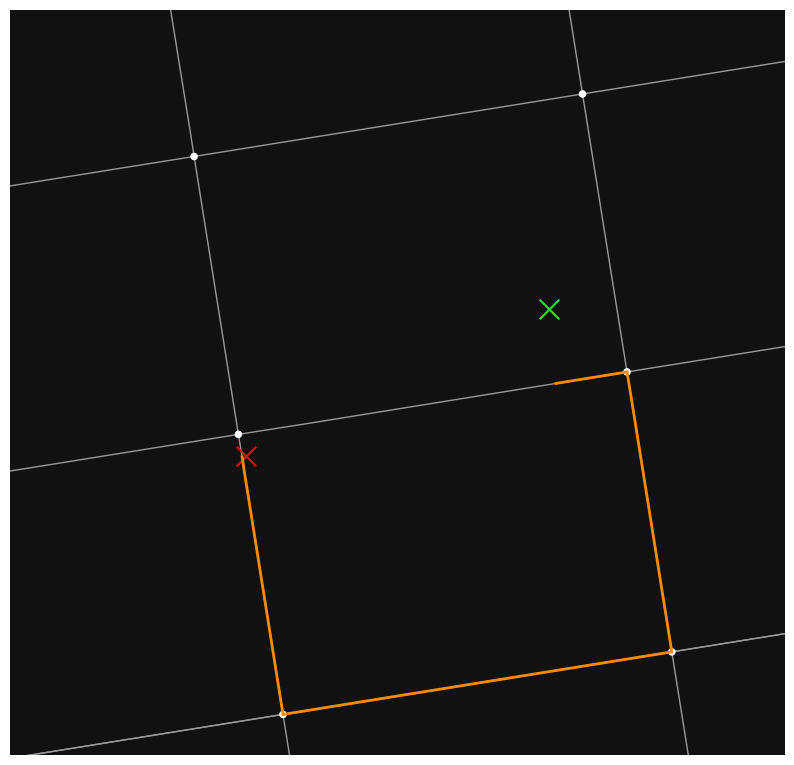

In [35]:
import taxicab as tc

# G = gdf.to_crs(epsg=3857)
# print(G.crs)
orig = (trip[1][1][0], trip[1][1][1])
dest = (trip[3][1][0], trip[3][1][1])
# print(ox.projection.is_projected(orig))
route = tc.distance.shortest_path(G, orig, dest)
fig, ax = tc.plot.plot_graph_route(G, route, node_size=30, show=False, close=False, figsize=(10,10))
padding = 0.001
ax.scatter(orig[1], orig[0], c='lime', s=200, label='orig', marker='x')
ax.scatter(dest[1], dest[0], c='red', s=200, label='dest', marker='x')
ax.set_ylim([min([orig[0], dest[0]])-padding, max([orig[0], dest[0]])+padding])
ax.set_xlim([min([orig[1], dest[1]])-padding, max([orig[1], dest[1]])+padding])
# plt.show()

orig = (trip[3][1][0], trip[3][1][1])
dest = (trip[4][1][0], trip[4][1][1])
route = tc.distance.shortest_path(G, orig, dest)
fig, ax = tc.plot.plot_graph_route(G, route, node_size=30, show=False, close=False, figsize=(10,10))
padding = 0.001
ax.scatter(orig[1], orig[0], c='lime', s=200, label='orig', marker='x')
ax.scatter(dest[1], dest[0], c='red', s=200, label='dest', marker='x')
ax.set_ylim([min([orig[0], dest[0]])-padding, max([orig[0], dest[0]])+padding])
ax.set_xlim([min([orig[1], dest[1]])-padding, max([orig[1], dest[1]])+padding])
# plt.show()

    
orig = (trip[4][1][0], trip[4][1][1])
dest = (trip[6][1][0], trip[6][1][1])
route = tc.distance.shortest_path(G, orig, dest)
fig, ax = tc.plot.plot_graph_route(G, route, node_size=30, show=False, close=False, figsize=(10,10))
padding = 0.001
ax.scatter(orig[1], orig[0], c='lime', s=200, label='orig', marker='x')
ax.scatter(dest[1], dest[0], c='red', s=200, label='dest', marker='x')
ax.set_ylim([min([orig[0], dest[0]])-padding, max([orig[0], dest[0]])+padding])
ax.set_xlim([min([orig[1], dest[1]])-padding, max([orig[1], dest[1]])+padding])
# plt.show()

In [26]:
%%time
# initialize the model
model = HMMModel(G, viterbi_trellis = [], viterbi_list = [])

# training
def train(data, candidate_roads):
    data = data.copy()
    num_iter = 0
    converged = False
    for obs in data:
        num_iter += 1
        fit_quality = model.update_dist(obs, candidate_roads[num_iter-1], num_iter, len(candidate_roads[num_iter-1]))
        if fit_quality == "Aborted":
            return "Aborted"
        print("On iteration %d, fit quality of MAX %3.2f, MEAN %3.2f, MEDIAN %3.2f" % 
              (num_iter, fit_quality[0], fit_quality[1], fit_quality[2]))
    print("Done.")

train(trip, candidate_roads)

On iteration 1, fit quality of MAX 0.50, MEAN 0.25, MEDIAN 0.25
On iteration 2, fit quality of MAX 0.02, MEAN 0.01, MEDIAN 0.01
On iteration 3, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
On iteration 4, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
On iteration 5, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
On iteration 6, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00


C:\Users\z1297\AppData\Local\Temp\ipykernel_7336\2489322459.py:67: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


On iteration 7, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00


C:\Users\z1297\AppData\Local\Temp\ipykernel_7336\2489322459.py:67: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


On iteration 8, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00


C:\Users\z1297\AppData\Local\Temp\ipykernel_7336\2489322459.py:67: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


On iteration 9, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00


C:\Users\z1297\AppData\Local\Temp\ipykernel_7336\2489322459.py:67: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.sum(probs)


On iteration 10, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
On iteration 11, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
On iteration 12, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
On iteration 13, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
On iteration 14, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
On iteration 15, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
Done.
CPU times: total: 35.4 s
Wall time: 35.7 s


# Get the result from model

In [27]:
backtracked_trace = []
backtracked_trace = model.viterbi()
print(backtracked_trace)

[[37.7865291, -122.4148222], [37.7865291, -122.4148222], [37.7865291, -122.4148222], [37.7853905, -122.416281], [37.7863197, -122.4164691], [37.7851818, -122.4179243], [37.7851818, -122.4179243], [37.7842457, -122.4177356], [37.7833151, -122.417548], [37.7814508, -122.4171732], [37.7814508, -122.4171732], [37.7814508, -122.4171732], [37.7804986, -122.4169901], [37.7807264, -122.4153391], [37.7807264, -122.4153391]]


# Visualization

In [28]:
# get the distance of trip
trip_list = []
for point in trip:
    trip_list.append([point[1].latitude, point[1].longitude])

total_dist_of_a_trip = 0
for i in range(len(trip_list) - 1):
    total_dist_of_a_trip += great_circle_dist_x_to_z(trip_list[i], trip_list[i+1])

# get the distance of matched
trip_list = []
for point in backtracked_trace:
    trip_list.append([point[0], point[1]])

total_dist_of_a_matched = 0
for i in range(len(trip_list) - 1):
    total_dist_of_a_matched += great_circle_dist_x_to_z(trip_list[i], trip_list[i+1])

# get the accuracy
# TODO: Find a better way to compute the accuracy
accuracy = np.abs(total_dist_of_a_trip-total_dist_of_a_matched)/total_dist_of_a_trip
print("The accuracy of our model: ", accuracy)

The accuracy of our model:  0.23855900850152467


In [29]:
# Add the standard road network

# Add the matched roads
matched_fg = folium.FeatureGroup(name='Matched Roads')

for i in range(len(trip_list)):

    # Draw traces
    if i < len(trip_list)-1:
        traces = folium.PolyLine(locations=[trip_list[i], trip_list[i+1]], weight=3, color='Green')
    
        node_end = folium.Marker(trip_list[i],
                    popup=(i),
                    icon = folium.Icon(color='red',icon=''))

        node_prev = folium.Marker(trip_list[i+1],
                popup=(i),
                icon = folium.Icon(color='blue',icon=''))

    matched_fg.add_child(node_end)
    matched_fg.add_child(node_prev)      
    # Add the polyline to the feature group
    matched_fg.add_child(traces)

""" # Candidate Roads

candidate_fg = folium.FeatureGroup(name='Candidate Roads')

# for i in range(len(candidate_roads)):
for j in range(len(candidate_roads[4]) -1):
    
    # Draw traces
    start_coord = [candidate_roads[4][j][1][2], candidate_roads[4][j][1][3]]
    end_coord = [candidate_roads[4][j][1][4], candidate_roads[4][j][1][5]]
    traces = folium.PolyLine(locations=[start_coord, end_coord], weight=3, color='Green')

    # Draw nodes
    node_end = folium.Marker(end_coord,
                popup=(i),
                icon = folium.Icon(color='red',icon=''))

    node_prev = folium.Marker(start_coord,
                popup=(i),
                icon = folium.Icon(color='blue',icon=''))

    # Add to the feature group
    candidate_fg.add_child(traces)
    candidate_fg.add_child(node_end)
    candidate_fg.add_child(node_prev)
"""

# Trip picked for HMM Training
trip_fg = folium.FeatureGroup(name='One Trip for HMM Training')

for i in range(len(trip)):

    # Draw traces
    current_coord = [trip[i][1][0], trip[i][1][1]]
    previous_coord = [trip[i][1][4], trip[i][1][5]]
    traces = folium.PolyLine(locations=[previous_coord, current_coord], weight=3, color='Blue')

    node_end = folium.Marker(previous_coord,
                popup=(i),
                icon = folium.Icon(color='red',icon=''))

    node_prev = folium.Marker(current_coord,
                popup=(i),
                icon = folium.Icon(color='blue',icon=''))

    trip_fg.add_child(node_end)
    trip_fg.add_child(node_prev)                             
    # Add to the feature group
    trip_fg.add_child(traces)

# Create a map centered at San Francisco
sf_map = folium.Map(location=[37.759457, -122.444781], zoom_start=12, prefer_canvas=True, control_scale=True)

# Add the feature groups to the map
sf_map.add_child(matched_fg)
sf_map.add_child(trip_fg)
# sf_map.add_child(candidate_fg)

# Add a layer control feature
folium.LayerControl().add_to(sf_map)

# Add click for coords feature
sf_map.add_child(folium.LatLngPopup())

# save map
#sf_map.save('SF_MAP.html')

# display map
sf_map

# Post Process

In [30]:
# print(backtracked_trace)
temple = backtracked_trace[3]
backtracked_trace[3] = backtracked_trace[4]
backtracked_trace[4] = temple
print(backtracked_trace)

[[37.7865291, -122.4148222], [37.7865291, -122.4148222], [37.7865291, -122.4148222], [37.7863197, -122.4164691], [37.7853905, -122.416281], [37.7851818, -122.4179243], [37.7851818, -122.4179243], [37.7842457, -122.4177356], [37.7833151, -122.417548], [37.7814508, -122.4171732], [37.7814508, -122.4171732], [37.7814508, -122.4171732], [37.7804986, -122.4169901], [37.7807264, -122.4153391], [37.7807264, -122.4153391]]


In [31]:
# calculate distance from node_z to line between node_x and node_y

# # create example nodes 
# perpendicular_fg = folium.FeatureGroup(name='distance')
# # "lat": 37.7092496, "lon": -122.4851812
# node_x_coord = [37.7865291, -122.4148222]
# # 65334133, 65317954
# #  "lat": 37.7863197, "lon": -122.4164691
# node_y_coord = [37.7863197, -122.4164691]
# #  65317954
# #  lat": 37.7853905, "lon": -122.416281
# node_z_coord = [37.7853905, -122.416281]
# # 65333831
# #  "lat": 37.7844547, "lon": -122.4160916
# node_n_coord = [37.7844547,-122.4160916]
# # 65333834
# # "lat": 37.7842457, "lon": -122.4177356
# node_m_coord = [37.7842457,-122.4177356]

# node_x = folium.Marker([node_x_coord[0], node_x_coord[1]],
#                   popup=('Latitude: 37.7900 Longitude: -122.5500'),
#                  icon = folium.Icon(color='green',icon=''))
# node_y = folium.Marker([node_y_coord[0], node_y_coord[1]],
#                   popup=('Latitude: 37.7900 Longitude: -122.5300'),
#                  icon = folium.Icon(color='red',icon=''))
# node_z = folium.Marker([node_z_coord[0], node_z_coord[1]],
#                   popup=('Latitude: 37.7950 Longitude: -122.5450'),
#                  icon = folium.Icon(color='blue',icon=''))
# node_n = folium.Marker([node_n_coord[0], node_n_coord[1]],
#                   popup=('Latitude: 37.7950 Longitude: -122.5450'),
#                  icon = folium.Icon(color='blue',icon=''))
# node_m = folium.Marker([node_m_coord[0], node_m_coord[1]],
#                   popup=('Latitude: 37.7950 Longitude: -122.5450'),
#                  icon = folium.Icon(color='blue',icon=''))
# # line = folium.PolyLine(locations=[node_x_coord, node_y_coord], weight=3, color='Black')

# perpendicular_fg.add_child(node_x)
# perpendicular_fg.add_child(node_y)
# perpendicular_fg.add_child(node_z)
# perpendicular_fg.add_child(node_n)
# perpendicular_fg.add_child(node_m)
# perpendicular_fg.add_child(line)


# c Roads
# c_fg = folium.FeatureGroup(name='C Roads')

# # for i in range(len(candidate_roads)):
# for i in range(len(trip)-1):
#     # Draw traces
#     current_coord = [trip[i+1][1][0], trip[i+1][1][1]]
#     previous_coord = [trip[i][1][0], trip[i][1][1]]
#     traces = folium.PolyLine(locations=[previous_coord, current_coord], weight=3, color='Blue')
    
#     # Draw nodes
#     node_end = folium.Marker(current_coord,
#                   popup=('End'),
#                  icon = folium.Icon(color='red',icon=''))

#     node_prev = folium.Marker(previous_coord,
#                   popup=('Previous'),
#                  icon = folium.Icon(color='blue',icon=''))

#     # Add to the feature group
#     c_fg.add_child(traces)
#     c_fg.add_child(node_end)
#     c_fg.add_child(node_prev)





# # Candidate Roads
# # candidate_fg = folium.FeatureGroup(name='Candidate Roads')

# # for i in range(len(candidate_roads)):
# # for j in range(len(candidate_roads)):
    
# #     # Draw traces
# #     start_coord = [candidate_roads[j][1][2], candidate_roads[j][1][3]]
# #     end_coord = [candidate_roads[j][1][4], candidate_roads[j][1][5]]
# #     traces = folium.PolyLine(locations=[start_coord, end_coord], weight=3, color='Green')

# #     # Draw nodes
# #     node_end = folium.Marker(end_coord,
# #                 popup=('End'),
# #                 icon = folium.Icon(color='red',icon=''))

# #     node_prev = folium.Marker(start_coord,
# #                 popup=('Previous'),
# #                 icon = folium.Icon(color='blue',icon=''))

# #     # Add to the feature group
# #     candidate_fg.add_child(traces)
# #     candidate_fg.add_child(node_end)
# #     candidate_fg.add_child(node_prev)

# Trip picked for HMM Training
trip_fg = folium.FeatureGroup(name='One Trip for HMM Training')

for i in range(len(trip)):

    # Draw traces
    current_coord = [trip[i][1][0], trip[i][1][1]]
    previous_coord = [trip[i][1][4], trip[i][1][5]]
    traces = folium.PolyLine(locations=[previous_coord, current_coord], weight=3, color='Blue')
    
    # Draw nodes
    node_end = folium.Marker(current_coord,
                  popup=('End'),
                 icon = folium.Icon(color='red',icon=''))

    node_prev = folium.Marker(previous_coord,
                  popup=('Previous'),
                 icon = folium.Icon(color='blue',icon=''))

    # Add to the feature group
    trip_fg.add_child(traces)
    trip_fg.add_child(node_end)
    trip_fg.add_child(node_prev)

    
# Add the matched roads
# point_fg = folium.FeatureGroup(name='P Roads')

# print(points_lists)

# for i in range(len(points_lists)):
#     # Draw traces
#     if i < len(points_lists)-1:
#         traces = folium.PolyLine(locations=[points_lists[i], points_lists[i+1]], weight=3, color='Green')
    
#     # Add the polyline to the feature group
#     point_fg.add_child(traces)

# Add the matched roads
matched_fg = folium.FeatureGroup(name='Matched Roads')

for i in range(len(backtracked_trace)):

    # Draw traces
    if i < len(backtracked_trace)-1:
        traces = folium.PolyLine(locations=[backtracked_trace[i], backtracked_trace[i+1]], weight=3, color='Green')
    
        node_end = folium.Marker(backtracked_trace[i],
                    popup=('End'),
                    icon = folium.Icon(color='red',icon=''))

        node_prev = folium.Marker(backtracked_trace[i+1],
                popup=('Previous'),
                icon = folium.Icon(color='blue',icon=''))

    matched_fg.add_child(node_end)
    matched_fg.add_child(node_prev)      
    # Add the polyline to the feature group
    matched_fg.add_child(traces)

# Create a map centered at San Francisco
sf_map = folium.Map(location=[37.759457, -122.444781], zoom_start=12, prefer_canvas=True, control_scale=True)


# Add the feature groups to the map
# sf_map.add_child(perpendicular_fg)
# sf_map.add_child(c_fg)
# # sf_map.add_child(candidate_fg)
sf_map.add_child(matched_fg)
sf_map.add_child(trip_fg)
# sf_map.add_child(point_fg)

# Add a layer control feature
folium.LayerControl().add_to(sf_map)

# Add click for coords feature
sf_map.add_child(folium.LatLngPopup())

# save map
#sf_map.save('SF_MAP.html')

# display map
sf_map


# Stage 2: Speed Estimation

## **Input**: output from Stage 1, 

## **Output**: traffic speed of each road segment.

In [32]:
matched_trace = backtracked_trace
prev_slope = None
theta = 0.2
time_for_one_road_segment = 0
start_point = []
end_point = []
speed_list = []
road_list = []

# match each point with the time 
for i in range(len(matched_trace) - 1):
    # get the slope of the function
    slope = get_slope(matched_trace[i], matched_trace[i+1])
    
    # if the previous slope is none, it means the car just started to move
    if prev_slope == None:
        start_point = matched_trace[i]
        time_for_one_road_segment += np.abs(trip[i][1]['time'] - trip[i+1][1]['time']).total_seconds()
        end_point = matched_trace[i+1]
        prev_slope = slope

    # else means the car is moving to one direction
    else:
        # if the new slope is in the range of the previous slope
        # it means the car is still in the same road segment
        if (prev_slope - theta) < slope < (prev_slope + theta) or prev_slope == 0:
            # add the time 
            time_for_one_road_segment += np.abs(trip[i][1]['time'] - trip[i+1][1]['time']).total_seconds()
            # record the end point
            end_point = matched_trace[i+1]
            prev_slope = slope

        # else it means the car change the road segment
        else:
            # if this is not the last node
            if (i + 1) != len(matched_trace) - 1:
                # compute the distance of the road segment
                distance = great_circle_dist_x_to_z(start_point, end_point)

                # compute the speed of the road segment 
                speed_for_one_road = distance / time_for_one_road_segment
                speed_list.append(speed_for_one_road * 2.236936)
                road_list.append([start_point, end_point])

                # reset everything
                time_for_one_road_segment = 0
                start_point = []
                end_point = []
                # record the slope and the new point
                time_for_one_road_segment += np.abs(trip[i][1]['time'] - trip[i+1][1]['time']).total_seconds()
                prev_slope = slope
                start_point = matched_trace[i]
                end_point = matched_trace[i+1]

            # if it is the last node
            else:
                time_for_one_road_segment += np.abs(trip[i][1]['time'] - trip[i+1][1]['time']).total_seconds()
                # compute the distance of the road segment
                distance = great_circle_dist_x_to_z(start_point, end_point)

                # compute the speed of the road segment 
                speed_for_one_road = distance / time_for_one_road_segment
                speed_list.append(speed_for_one_road * 2.236936 )
                road_list.append([start_point, end_point])

final_speed_list = []
final_road_list = []
temple_speed = 0
num_combine = 1

# one more check to see if there are some path should combine
for i in range(len(road_list) - 1):
    slope1 = get_slope(road_list[i][0], road_list[i][1])
    slope2 = get_slope(road_list[i+1][0], road_list[i+1][1])
    
    if slope1 == slope2:
        temple_speed = speed_list[i] + speed_list[i+1]
        num_combine += 1
    else:
        if temple_speed == 0:
            final_speed_list.append(speed_list[i])
            final_road_list.append([road_list[i][0], road_list[i][1]])
        else:
            final_speed_list.append(temple_speed/num_combine)
            final_road_list.append([road_list[i-num_combine+1][0], road_list[i][1]])
            
            temple_speed = 0
            num_combine = 1
        if (i + 1) == len(road_list) - 1:
            final_speed_list.append(speed_list[i + 1])
            final_road_list.append([road_list[i + 1][0], road_list[i + 1][1]])
            
print("--------------------------------------Final Result--------------------------------------")
for i in range(len(final_speed_list)):
    print("For road segment",final_road_list[i], ", we have speed: ")
    print(final_speed_list[i], "mph")

# make a file that have each edgeID and the corresponding speed

# find the nearest edges
# for i in range(len(road_list)-1):
#     edgeID = ox.nearest_edges(G, road_list[i][0], road_list[i][1])
#     print(edgeID)
    # add pairs of edgeID and the corresponding speed to the file
    

#     print(matched_trace[i])
#     print(trip[i][1]['time'])

# [37.7865291, -122.4148222],0 
# [37.7865291, -122.4148222],1 
# [37.7865291, -122.4148222],2 
# [37.7863197, -122.4164691],3 
# [37.7853905, -122.416281],4
# [37.7851818, -122.4179243], 5
# [37.7851818, -122.4179243], 6
# [37.7842457, -122.4177356], 7
# [37.7833151, -122.417548],  8
# [37.7814508, -122.4171732], 9
# [37.7814508, -122.4171732], 10
# [37.7814508, -122.4171732], 11
# [37.7804986, -122.4169901], 12
# [37.7807264, -122.4153391],    13
# [37.7807264, -122.4153391]     14

--------------------------------------Final Result--------------------------------------
For road segment [[37.7865291, -122.4148222], [37.7863197, -122.4164691]] , we have speed: 
7.625679946353029 mph
For road segment [[37.7863197, -122.4164691], [37.7853905, -122.416281]] , we have speed: 
15.60430239716806 mph
For road segment [[37.7853905, -122.416281], [37.7851818, -122.4179243]] , we have speed: 
21.81218729316482 mph
For road segment [[37.7851818, -122.4179243], [37.7804986, -122.4169901]] , we have speed: 
11.486645468002353 mph
For road segment [[37.7804986, -122.4169901], [37.7807264, -122.4153391]] , we have speed: 
10.982711664608733 mph


# Stage 3: Personalized Travel Time Prediction

## **Input**:  the vehicle id, the origin and time, the destination

## **Output**: predicted travel time.

In [33]:
# first we get the shortest path using ox

# given each NodeID, we first visualize the shortest path

# then, we measure the distance,

# find the edgeID, and get the speed

# then for each road, compute the time and sum them together